In [ ]:
# 参考記事
# https://qiita.com/yottyann1221/items/20a9c8a7a02edc7cd3d1#%E6%A6%82%E8%A6%81
# https://qiita.com/yottyann1221/items/d465c033dd70b2e53598

In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# !unzip /content/drive/MyDrive/FaceEdited.zip

Archive:  FaceEdited.zip
replace FaceEdited/ishihara/93_0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: FaceEdited/ishihara/93_0.jpg  
replace FaceEdited/ishihara/217_0thr.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# !unzip /content/drive/MyDrive/test.zip

In [25]:
import os
from keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Activation, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
import numpy as np
import time

In [26]:
# 分類するクラス
# classes = ["広瀬すず","新垣結衣","石原さとみ","武井咲"]
classes = ["hirose","aragaki","ishihara","takei"]
nb_classes = len(classes)
#画像の大きさを設定
img_width, img_height = 150, 150

# トレーニング用とバリデーション用の画像格納先（パスは自分で設定してください）
train_data_dir = '/content/FaceEdited'
validation_data_dir = '/content/test'

#トレーニングデータ用の画像数
# nb_train_samples = 7000
nb_train_samples = 9000
#バリデーション用の画像数
# nb_validation_samples = 1000
nb_validation_samples = 2000
#バッチサイズ
batch_size = 100
#エポック数
nb_epoch = 20

In [27]:
# トレーンング用、バリデーション用データを生成するジェネレータ作成
train_datagen = ImageDataGenerator(
  rescale=1.0 / 255,
  #すでに画像の水増し済みの方は、下記２行は必要ありません。
  #zoom_range=0.2,
  #horizontal_flip=True
)

validation_datagen = ImageDataGenerator(rescale=1.0 / 255)

# flow_from_directory：元画像が含まれるディレクトリ名を指定する
# target_size:画像のサイズをリサイズする
# class_mode:2クラス分類ならbinary、多クラス分類ならcategoricalを指定する

train_generator = train_datagen.flow_from_directory(
  train_data_dir,
  target_size=(img_width, img_height),
  color_mode='rgb',
  classes=classes,
  class_mode='categorical',
  batch_size=batch_size,
  shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
  validation_data_dir,
  target_size=(img_width, img_height),
  color_mode='rgb',
  classes=classes,
  class_mode='categorical',
  batch_size=batch_size,
  shuffle=True)

Found 9095 images belonging to 4 classes.
Found 2272 images belonging to 4 classes.


In [28]:
from tensorflow import keras

keras.applications.vgg16.VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)

In [30]:
# VGG16のロード。FC層は不要なので include_top=False
input_tensor = Input(shape=(img_width, img_height, 3))
vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)

# VGG16の図の緑色の部分（FC層）の作成
top_model = Sequential()
top_model.add(Flatten(input_shape=vgg16.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(nb_classes, activation='softmax'))

# VGG16とFC層を結合してモデルを作成（完成図が上の図）
vgg_model = Model(inputs=vgg16.input, outputs=top_model(vgg16.output))

# VGG16の図の青色の部分は重みを固定（frozen）
for layer in vgg_model.layers[:15]:
    layer.trainable = False

# 多クラス分類を指定
vgg_model.compile(loss='categorical_crossentropy',
          optimizer=optimizers.SGD(learning_rate=1e-3, momentum=0.9),
          metrics=['accuracy'])

In [39]:
# train_data_gen	学習データのジェネレータ（学習データ）
# steps_per_epoch	学習データに対して、1つのエポックを宣言し、次のエポックを開始するまでの合計ステップ数
# total_train	学習データの合計数（ここでは2000）
# epochs	学習データ全体を学習するまでの反復数（ここでは15を指定）
# validation_data	検証用データ
# val_data_gen	検証データのジェネレータ
# validation_steps	検証データに対して、1つのエポックを宣言し、次のエポックを開始するまでの合計ステップ数
# total_val	検証データの合計数（ここでは2000）
# batch_size	重み更新ごとのサンプル数

# epochs引数は、学習データ全体を何巡ぶん学習するかを示します。
# steps_per_epoch引数は、DNNの計算を何回行うと学習データを一巡したことになるかを指定します。
# 上述の通りDNNには学習データをbatch_size個ずつ小分けにして与えますので、学習データ全体の数をbatch_sizeで割った値を指定します。
# validation_steps引数は、DNNの計算を何回行うと検証データを一巡したことになるかを指定します。検証データ全体の数をbatch_sizeで割った値を指定します。

# Fine-tuning
history = vgg_model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=nb_epoch,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

Epoch 1/20
90/90 [==============================] - 23s 252ms/step - loss: 0.0451 - accuracy: 0.9878 - val_loss: 0.0582 - val_accuracy: 0.9815
Epoch 2/20
90/90 [==============================] - 23s 259ms/step - loss: 0.0300 - accuracy: 0.9902 - val_loss: 0.0479 - val_accuracy: 0.9870
Epoch 3/20
90/90 [==============================] - 24s 261ms/step - loss: 0.0208 - accuracy: 0.9953 - val_loss: 0.0371 - val_accuracy: 0.9890
Epoch 4/20
90/90 [==============================] - 23s 256ms/step - loss: 0.0139 - accuracy: 0.9974 - val_loss: 0.0375 - val_accuracy: 0.9875
Epoch 5/20
90/90 [==============================] - 23s 258ms/step - loss: 0.0129 - accuracy: 0.9978 - val_loss: 0.0354 - val_accuracy: 0.9860
Epoch 6/20
90/90 [==============================] - 23s 255ms/step - loss: 0.0090 - accuracy: 0.9982 - val_loss: 0.0356 - val_accuracy: 0.9890
Epoch 7/20
90/90 [==============================] - 23s 251ms/step - loss: 0.0076 - accuracy: 0.9989 - val_loss: 0.0257 - val_accuracy: 0.9925

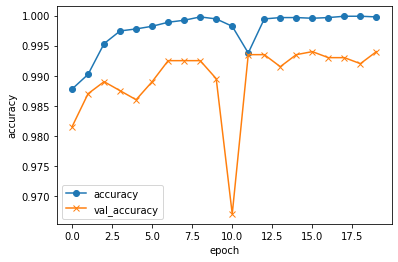

In [40]:
# 学習結果を描写
import matplotlib.pyplot as plt

#acc, val_accのプロット
plt.plot(history.history["accuracy"], label="accuracy", ls="-", marker="o")
plt.plot(history.history["val_accuracy"], label="val_accuracy", ls="-", marker="x")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(loc="best")
#Final.pngという名前で、結果を保存
plt.savefig('Final.png')
plt.show()

In [41]:
import os
#resultsディレクトリを作成
result_dir = 'results'
if not os.path.exists(result_dir):
    os.mkdir(result_dir)

# 重みを保存
vgg_model.save_weights(os.path.join(result_dir, 'Final.h5'))

# 作成したモデルを保存
vgg_model.save('VGGtake1.h5')

In [42]:
# テスト用のコード
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import  load_model

vgg_model = load_model('/content/VGGtake1.h5')

# 画像を読み込んで予測する
def img_predict(filename):
    # 画像を読み込んで4次元テンソルへ変換
    img = image.load_img(filename, target_size=(img_height, img_width))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    # 学習時にImageDataGeneratorのrescaleで正規化したので同じ処理が必要
    # これを忘れると結果がおかしくなるので注意
    x = x / 255.0   
    #表示
    plt.imshow(img)
    plt.show()
    # 指数表記を禁止にする
    np.set_printoptions(suppress=True)

    #画像の人物を予測    
    pred = vgg_model.predict(x)[0]
    #結果を表示する
    print("　　広瀬すず': 0, '新垣結衣': 1, '石原さとみ': 2, '武井咲': 3")
    print(pred*100)

In [66]:
import glob
#テスト用の画像が入っているディレクトリのpathを()に入れてください
# test = glob.glob('/content/test/*')
test = glob.glob('/content/test/aragaki/*')

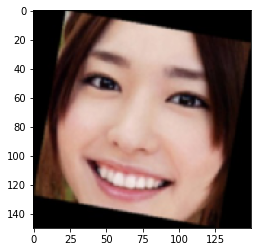

　　広瀬すず': 0, '新垣結衣': 1, '石原さとみ': 2, '武井咲': 3
[  0.00000019 100.           0.00000001   0.00000015]


In [67]:
#数字は各自入力
img_predict(test[0])
# test[0]